In [1]:
import os
from astropy.cosmology import Planck15 as cosmo
import colossus.cosmology.cosmology as colossus_cosmo
import colossus.lss.mass_function as colossus_mf
import colossus.halo.concentration as colossus_conc
import galsim
from scipy.interpolate import interp1d
from scipy.integrate import quad

from AbundanceMatching import AbundanceFunction

In [2]:
galsim_cosmo = galsim.Cosmology(omega_m=cosmo.Om0, omega_lam=1-cosmo.Om0)

In [3]:
DATA_DIR = os.curdir
#DATA_DIR = '../SAGA/data/'
OUTPUT_DIR = os.path.join(os.getenv('HOME', os.curdir), 'Downloads')

## construct halo mass -- luminosity relation

/home/yymao/miniconda3/lib/python3.6/site-packages/AbundanceMatching/AbundanceFunction.py:232: RuntimeWarning: invalid value encountered in true_divide
  phi_int = dphi/_diff(phi_log_new)*dx


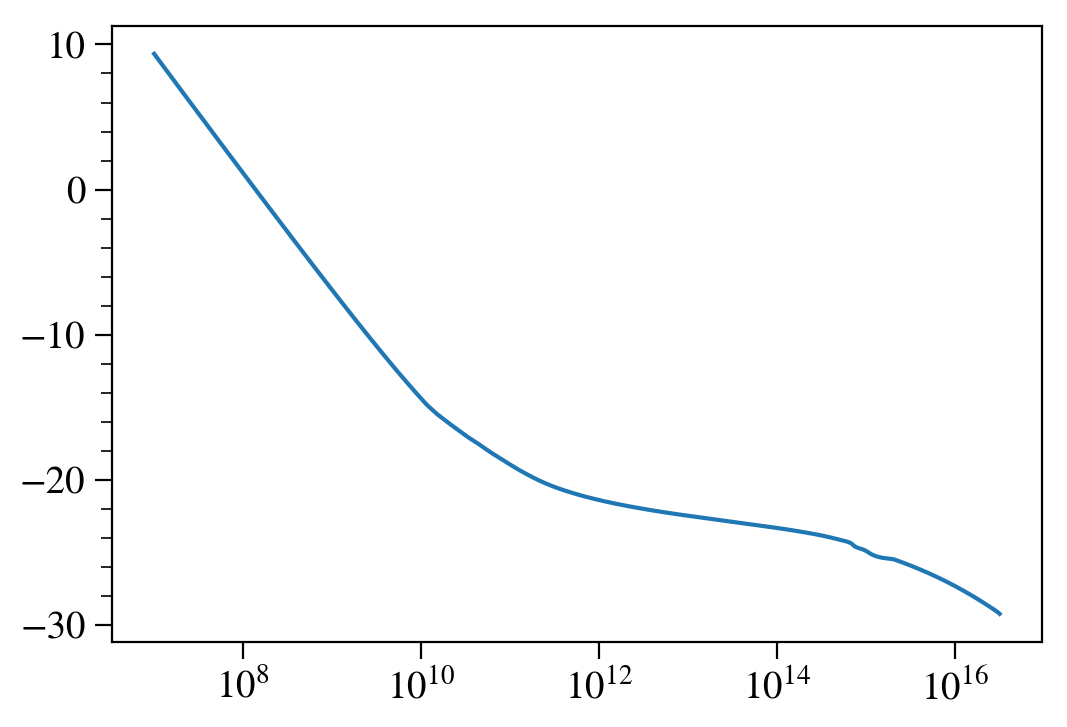

In [4]:
colossus_cosmo.setCosmology('planck15')
m = np.logspace(7, 16.5, 1001)[::-1]
n = np.cumsum(colossus_mf.massFunction(m, z=0.0, mdef='200c', q_out='dndlnM'))
n *= np.log(m[0]/m[1])
n *= cosmo.h**3.0

gama_lf = np.loadtxt(os.path.join(DATA_DIR, 'GAMA_LF.txt'), skiprows=1, usecols=(1, 2))
# convert from h=1 to h!=1 unit
gama_lf[:,0] += np.log10(cosmo.h) * 5.0
gama_lf[:,1] *= cosmo.h**3.0
af = AbundanceFunction(*gama_lf[0:-7].T, ext_range=(-30, 10), faint_end_fit_points=10)

log_mass_to_Mr = interp1d(np.log10(m[::-1]), af.match(n[::-1]), 'cubic')
plt.semilogx(m, log_mass_to_Mr(np.log10(m)))

## limiting redshift

In [5]:
z = np.concatenate([np.logspace(-6, -3, 31), np.linspace(0.001, 3, 1001)[1:]])
mu = cosmo.distmod(z).to('mag').value
distmod_to_z = interp1d(mu, z,'cubic')

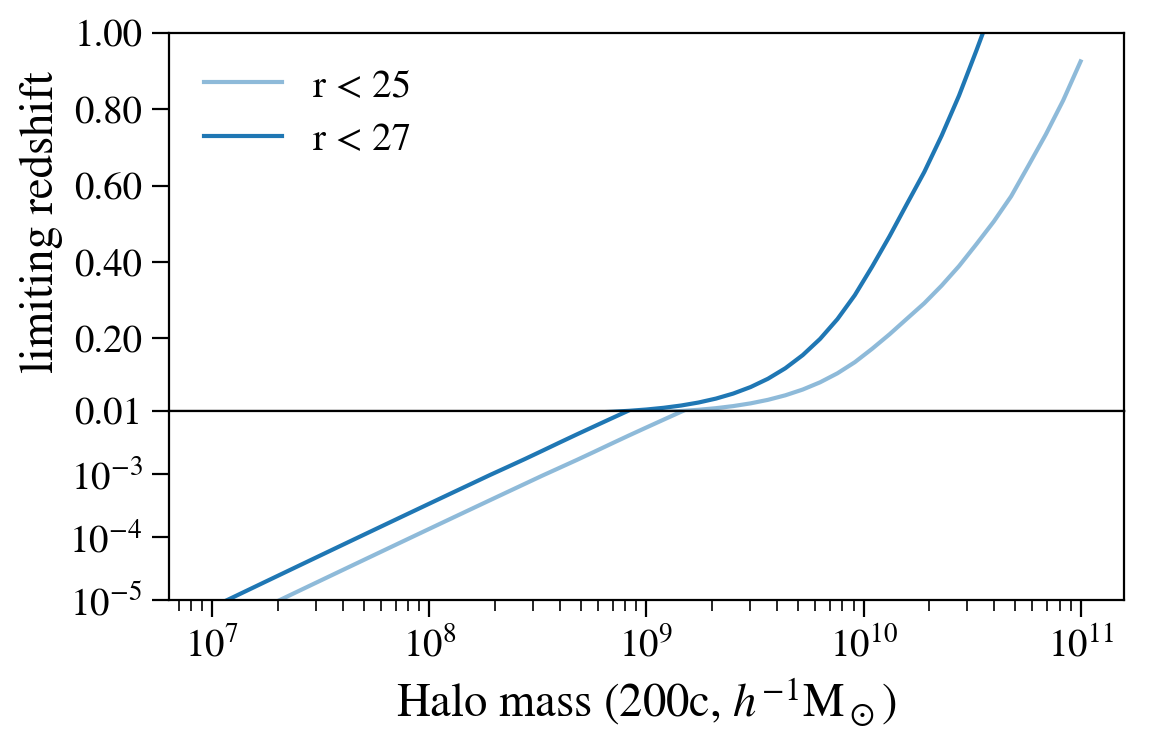

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[2,1]})
logm = np.linspace(7, 11, 51)
mag = log_mass_to_Mr(logm)
ax[0].semilogx(10.0**logm, distmod_to_z(25 - mag), label='r < 25', c='C0', alpha=0.5)
ax[0].semilogx(10.0**logm, distmod_to_z(27 - mag), label='r < 27', c='C0')
ax[1].loglog(10.0**logm, distmod_to_z(25 - mag), label='r < 25', c='C0', alpha=0.5)
ax[1].loglog(10.0**logm, distmod_to_z(27 - mag), label='r < 27', c='C0')
ax[1].set_xlabel('Halo mass (200c, $h^{-1}{\\rm M}_\\odot$)')
ax[0].set_ylabel('limiting redshift')
ax[0].set_ylim(0.01, 1)
ax[0].set_yticks([0.01, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[0].set_yticks([], minor=True)
ax[1].set_ylim(1e-5, 0.01)
ax[1].set_yticks([1e-5, 1e-4, 1e-3])
ax[0].legend()
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'halo_mass_redshift.pdf'))

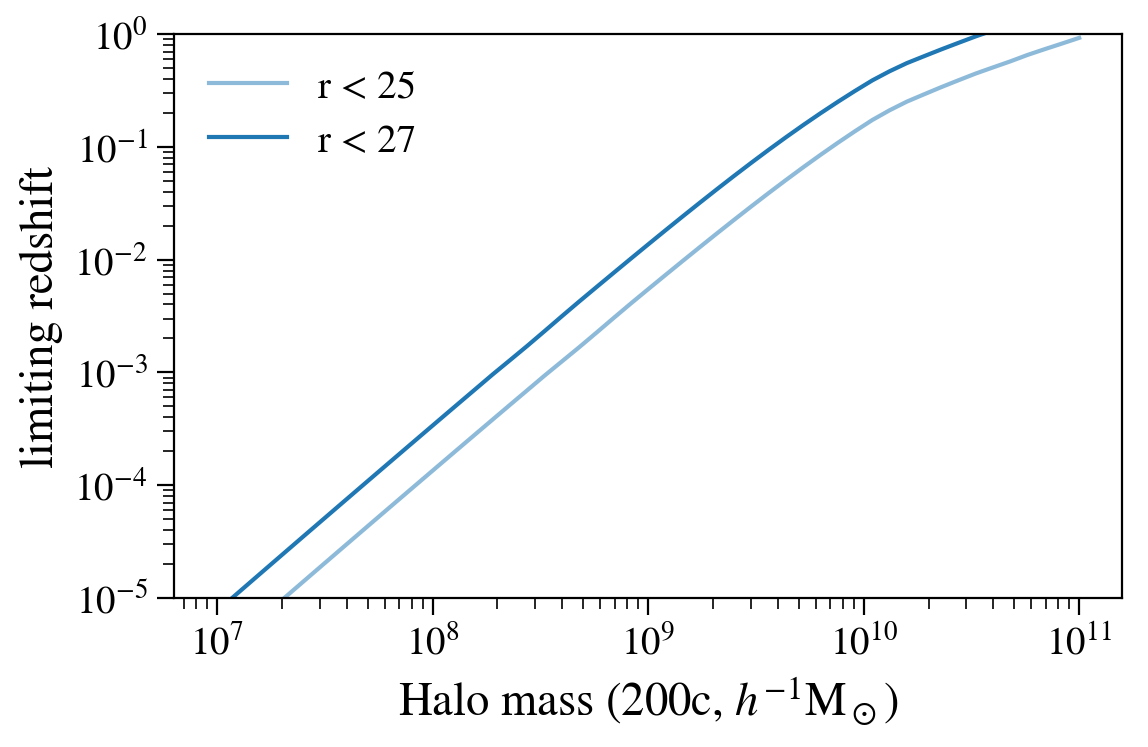

In [6]:
fig, ax = plt.subplots()
logm = np.linspace(7, 11, 51)
mag = log_mass_to_Mr(logm)
ax.loglog(10.0**logm, distmod_to_z(25 - mag), label='r < 25', c='C0', alpha=0.5)
ax.loglog(10.0**logm, distmod_to_z(27 - mag), label='r < 27', c='C0')
ax.set_xlabel('Halo mass (200c, $h^{-1}{\\rm M}_\\odot$)')
ax.set_ylabel('limiting redshift')
ax.set_ylim(1e-5, 1)
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'halo_mass_redshift_log.pdf'))

In [7]:
target_halo_mass = 1e10
dlogM = 0.5
dz = 0.1
limiting_mag = 27
sky_area = 16000

In [8]:
z_s = 1.2
n_eff = 50.0 # per arcmin^2
sigma_gamma = 0.25 # per component

In [9]:
rp_bin_edges = np.logspace(1, 3, 21)
rp_bin_mid = np.sqrt(rp_bin_edges[1:] * rp_bin_edges[:-1])

In [10]:
def signal_to_noise(target_halo_mass):
    Mr = log_mass_to_Mr(np.log10(target_halo_mass))
    limiting_redshift = distmod_to_z(limiting_mag - Mr)
    limiting_redshift_low = max(0, limiting_redshift - dz)

    vol = (cosmo.comoving_volume(limiting_redshift).value - cosmo.comoving_volume(limiting_redshift_low).value)
    vol *= (sky_area / np.rad2deg(np.rad2deg(4*np.pi)))
    
    nd = quad(lambda ln_m: colossus_mf.massFunction(np.exp(ln_m), z=limiting_redshift, mdef='200c', q_out='dndlnM'), 
             np.log(target_halo_mass), np.log(target_halo_mass*10.0**dlogM))[0] * cosmo.h**3.0 
    
    n_lens = vol * nd
    print('m200c={:.0E}, z={:.3f}, n={:.2E}, Mr={:.1f}'.format(target_halo_mass, limiting_redshift, n_lens, Mr))
    conc = colossus_conc.concentration(target_halo_mass, '200c', limiting_redshift, model='diemer18')
    
    ang_sep_arcsec = np.rad2deg(rp_bin_mid / cosmo.angular_diameter_distance(limiting_redshift).to('kpc').value) * 3600
    input_pos = (ang_sep_arcsec, np.zeros_like(ang_sep_arcsec))
    
    rp_bin_edges_arcmin = np.rad2deg(rp_bin_edges / cosmo.angular_diameter_distance(limiting_redshift).to('kpc').value) * 60
    annulus_area_arcmin = np.pi * (rp_bin_edges_arcmin[1:]**2 - rp_bin_edges_arcmin[:-1]**2)

    n_src = annulus_area_arcmin * n_eff
    n_lens_src = n_src * n_lens
    shape_noise = sigma_gamma / np.sqrt(n_lens_src)
    
    nfw = galsim.NFWHalo(mass=target_halo_mass,
                         conc=conc, redshift=limiting_redshift,
                         cosmo=galsim_cosmo)
    gamma_t = np.hypot(*nfw.getShear(pos=input_pos, z_s=z_s))
    
    return gamma_t, shape_noise

m200c=1E+10, z=0.349, n=1.21E+08, Mr=-14.4
m200c=3E+09, z=0.072, n=7.83E+06, Mr=-10.6
m200c=1E+09, z=0.014, n=1.63E+05, Mr=-6.9


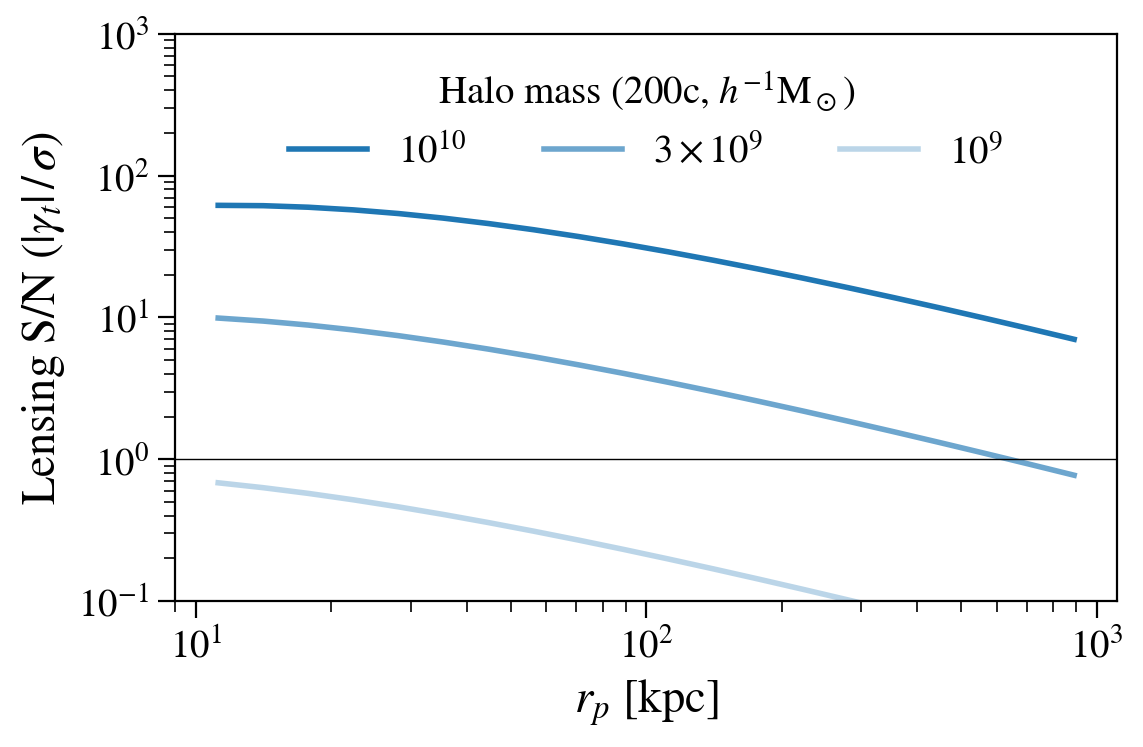

In [12]:
gamma_t, shape_noise = signal_to_noise(1e10)
plt.loglog(rp_bin_mid, gamma_t/shape_noise, label='$10^{10}$', c='C0', alpha=1, lw=2)
gamma_t, shape_noise = signal_to_noise(3e9)
plt.loglog(rp_bin_mid, gamma_t/shape_noise, label='$3\\times10^9$', c='C0', alpha=0.65, lw=2)
gamma_t, shape_noise = signal_to_noise(1e9)
plt.loglog(rp_bin_mid, gamma_t/shape_noise, label='$10^9$', c='C0', alpha=0.3, lw=2)
plt.xlabel('$r_p$ [kpc]')
plt.ylabel('Lensing S/N ($|\\gamma_t|\,/\,\sigma$)')
plt.legend(title='Halo mass (200c, $h^{-1}{\\rm M}_\\odot$)', ncol=3, loc='upper center')
plt.ylim(1e-1, 1000)
plt.axhline(1, c='k', lw=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'halo_mass_lensing_sn.pdf'))